In [1]:
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import skorch
from imageio import imread
from tqdm import tqdm

In [2]:

from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

from skorch import NeuralNetClassifier

In [34]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


def classification_complete_report(y_true, y_pred ,labels = None  ): 
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    cm = confusion_matrix(y_true, y_pred,labels= labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(15*"----")

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla V100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
data_path = "/storage/groups/qscd01/datasets/191024_AML_Matek/train_val_test/"

In [5]:
# creating metadata of files

metadata = pd.DataFrame(columns=["file", "label", "set"])

In [6]:
## train 
metadata_dummy =pd.DataFrame(columns=["file", "label", "set"])
metadata_dummy["file"] = glob(data_path +  "train/*.tiff")
metadata_dummy["label"] = "unknown"
metadata_dummy["set"] = "train"

metadata = metadata.append(metadata_dummy, ignore_index = True)

## val 
metadata_dummy =pd.DataFrame(columns=["file", "label", "set"])
metadata_dummy["file"] = glob(data_path +  "val/*.tiff")
metadata_dummy["label"] = "unknown"
metadata_dummy["set"] = "val"

metadata = metadata.append(metadata_dummy, ignore_index = True)


## test
metadata_dummy =pd.DataFrame(columns=["file", "label", "set"])
metadata_dummy["file"] = glob(data_path +  "test/*.tiff")
metadata_dummy["label"] = "unknown"
metadata_dummy["set"] = "test"

metadata = metadata.append(metadata_dummy, ignore_index = True)
metadata_dummy = None

metadata["label"] = metadata["file"].str.replace("/storage/groups/qscd01/datasets/191024_AML_Matek/train_val_test/", "") 
metadata["label"] = metadata["label"].str.replace("train/", "") 
metadata["label"] = metadata["label"].str.replace("val/", "") 
metadata["label"] = metadata["label"].str.replace("test/", "") 
metadata["label"] = metadata["label"].str.split("_", n = 0, expand = True).loc[:,0]


In [7]:
label_map = dict()

for i,cl in enumerate(metadata.label.unique()):
    label_map[cl] = i
    
label_map

{'NGS': 0,
 'LYT': 1,
 'MON': 2,
 'MYO': 3,
 'NGB': 4,
 'EOS': 5,
 'EBO': 6,
 'BAS': 7,
 'PMO': 8,
 'MYB': 9,
 'MOB': 10,
 'KSC': 11,
 'MMZ': 12,
 'PMB': 13,
 'LYA': 14}

In [9]:
from torch.utils.data import Dataset, DataLoader
import copy

class DatasetGenerator(Dataset):

    def __init__(self, 
                metadata, 
                reshape_size=64, 
                label_map=[],
                transform=None,
                selected_channels = [0]):

        self.metadata = metadata.copy().reset_index(drop = True)
        self.reshape_size = reshape_size
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        ## get image and label
        h5_file_path = self.metadata.loc[idx,"file"]
        image= imread(h5_file_path)[:,:,selected_channels]
        image = np.transpose(image, (2, 0, 1))
        label = self.metadata.loc[idx,"label"]
 

        # map numpy array to tensor
        image = torch.from_numpy(copy.deepcopy(image)) 
        image = image.float()
        
        if self.transform:
            image = self.transform(image) 
        
        label = self.label_map[label]
        label = torch.tensor(label).long()
        return image.float(),  label
        
        

def get_statistics(dataloader, nmb_channels ):

    statistics = dict()
    
    statistics["mean"] = torch.zeros(nmb_channels)
    statistics["std"] = torch.zeros(nmb_channels)
    for _, data_l in enumerate(tqdm(dataloader), 0):
        image, _ = data_l
        for n in range(nmb_channels):

            statistics["mean"][n] += image[:, n, :, :].mean()
            statistics["std"][n] += image[:, n, :, :].std()

    # averaging
    for k in statistics:
        statistics[k] = statistics[k].div_(len(dataloader))

    print('statistics used: %s' % (str(statistics)))

    return statistics

In [10]:
train_index = metadata.set == "train"
val_index = metadata.set == "val"
test_index = metadata.set == "test"

In [11]:
selected_channels = [0,1,2]

In [12]:
reshape_size = 64

train_dataset = DatasetGenerator(metadata.loc[train_index ,:], #
                                 reshape_size=reshape_size, 
                                label_map=label_map,
                                transform=None,
                                selected_channels=selected_channels)

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 4)

In [14]:
stats = get_statistics(train_loader,nmb_channels=len(selected_channels) )

100%|██████████| 2/2 [00:03<00:00,  1.73s/it]

statistics used: {'mean': tensor([209.5826, 186.7472, 214.0639]), 'std': tensor([42.9258, 65.5434, 25.4092])}


In [15]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [18]:
import torch.nn as nn
from torchvision.models import resnet18
import torch.nn.functional as F

class ResNet18Pretrained(nn.Module):
    def __init__(self,  
                 num_channels=3, 
                 num_classes=3, 
                 pretrained=True ,**kwargs):
        
        super().__init__()
        model = resnet18(pretrained=True) 
        if num_channels != 3:
            model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(7, 7),
                                        stride=(2, 2), padding=(3, 3), bias=False)
        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        self.model = model

    def forward(self, x):                
        return self.model(x)

In [19]:
resnet_pretrained = ResNet18Pretrained(num_channels=3 , num_classes = len(metadata.label.unique()) )

In [27]:

from torchvision import transforms
eps = 1e-16
stats["std"] = stats["std"] + eps
train_transform = transforms.Compose([ 
        torchvision.transforms.Normalize(
                mean=stats["mean"],
                std=stats["std"],
            ),
        transforms.RandomResizedCrop(reshape_size, scale=(0.8, 1.0), ratio=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.02),
])



train_dataset = DatasetGenerator(metadata.loc[train_index ,:], 
                                 reshape_size=reshape_size, 
                                label_map=label_map, 
                                 transform = train_transform)

val_transform = transforms.Compose([ 
        torchvision.transforms.Normalize(
                mean=stats["mean"],
                std=stats["std"],
            ),
        transforms.Resize(reshape_size)])


val_dataset = DatasetGenerator(metadata.loc[val_index,:], 
                                 reshape_size=reshape_size, 
                                label_map=label_map, 
                                 transform = val_transform)



test_dataset = DatasetGenerator(metadata.loc[test_index,:], 
                                 reshape_size=reshape_size, 
                                label_map=label_map, 
                                 transform = val_transform)

In [28]:
test_dataset[0][0].shape

torch.Size([3, 64, 64])

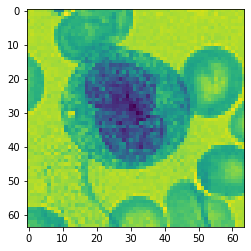

In [29]:
plt.imshow(test_dataset[0][0][0,:,:])

In [30]:


lr_scheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.6)
checkpoint = Checkpoint(f_params='resnet_18_aml.pth', monitor='valid_acc_best')


epoch_scoring = EpochScoring("f1_macro", name = 
                       "valid_f1_macro",
                       on_train = False,
                       lower_is_better = False)

early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                               patience=50, 
                               threshold=0.0001, 
                               threshold_mode='rel', 
                               lower_is_better=False)

model = NeuralNetClassifier(    
    resnet_pretrained, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=64,
    max_epochs=1000,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=3,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=1,
    callbacks=[lr_scheduler,checkpoint, epoch_scoring, early_stopping],
    train_split=predefined_split(val_dataset),
    device="cuda",
    warm_start=True)

In [31]:
model = model.fit(train_dataset, y = None)

  epoch    train_loss    valid_acc    valid_f1_macro    valid_loss    cp      lr      dur
-------  ------------  -----------  ----------------  ------------  ----  ------  -------
      1        0.6999       0.9020            0.3887        0.5159     +  0.0010  58.3199
      2        0.3849       0.8620            0.3623        0.4466        0.0010  8.7134
      3        0.3541       0.8780            0.3789        0.3855        0.0010  4.2170
      4        0.2892       0.9280            0.4076        0.2754     +  0.0010  4.1459
      5        0.2538       0.9020            0.3884        0.2685        0.0010  4.2323
      6        0.2208       0.9300            0.4119        0.2531     +  0.0006  4.1973
      7        0.1905       0.9420            0.4217        0.2437     +  0.0006  4.3144
      8        0.1863       0.9240            0.4139        0.2479        0.0006  4.3000
      9        0.1764       0.9260            0.4827        0.2863        0.0006  4.1629
     10        0.1

In [32]:
model.module.load_state_dict(torch.load('resnet_18_aml.pth')) 


<All keys matched successfully>

/home/icb/sayedali.boushehri/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/sayedali.boushehri/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/sayedali.boushehri/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       246
           1       0.93      0.99      0.96       112
           2       0.86      0.84      0.85        43
           3       0.95      0.87      0.91        79
           4       0.00      0.00      0.00         1
           5       1.00      0.92      0.96        13
           6       0.00      0.00      0.00         1
           7       0.50      0.50      0.50         2
           8       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.95       500
   macro avg       0.47      0.47      0.47       500
weighted avg       0.94      0.95      0.95       500

------------------------------------------------------------
matthews correlation coeff: 0.9257
Cohen Kappa score: 0.9253
Accuracy: 0.9500 & balanced Accuracy: 0.4659
macro F1 score: 0.46

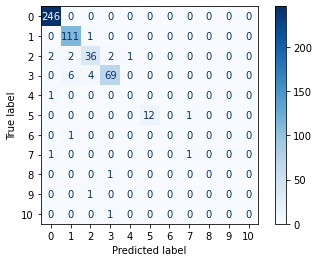

------------------------------------------------------------


In [35]:
preds = model.predict(val_dataset)

classification_complete_report([label_map[t] for t in val_dataset.metadata.label], 
                               preds  )

/home/icb/sayedali.boushehri/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/sayedali.boushehri/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/sayedali.boushehri/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       237
           1       0.86      0.98      0.92       107
           2       0.91      0.82      0.86        49
           3       0.95      0.91      0.93        85
           5       0.89      0.89      0.89         9
           6       1.00      0.83      0.91         6
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1

    accuracy                           0.94       500
   macro avg       0.43      0.42      0.42       500
weighted avg       0.93      0.94      0.93       500

------------------------------------------------------------
matthews correlati

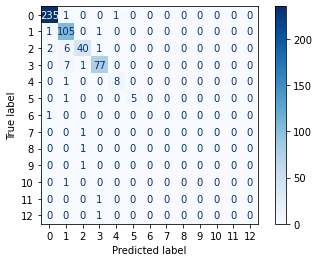

------------------------------------------------------------


In [36]:
preds = model.predict(test_dataset)
#preds =  [inv_map[int(t)] for t in preds]

classification_complete_report([label_map[t] for t in test_dataset.metadata.label],  preds   )